In [1]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Fs = 1000 # Sampling frequency of all measurements

c shared library imported successfully!
Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [108]:
'''
General Functions
'''

def aPlot(figName='', is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure):           
    filtData = lowpassFilter(rawData, 5, Fs, 8) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])


In [3]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.4,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.4,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.4,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.4,'Bi',6900,'Wearable','20211008']
]
condiTable = pd.DataFrame(condiTable, columns = colNames)
# condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
# materialProperty.to_csv("MaterialProperty.csv", index=False)

In [ ]:
''' Design and zipping state '''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
#stateLayout.to_csv("StateLayout.csv", index=False)


In [ ]:
''' Generate model by matched parameters after getting model data of Valid Arc Length '''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

#md.to_csv("ValidArcLength.csv", index=False)
md.head(1)    

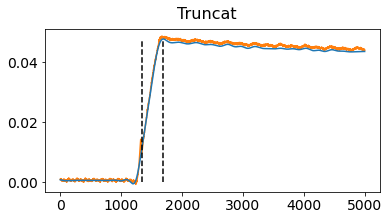


6mLBOPP12 - Trial06
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.049 (bar) in 0.346 (sec)



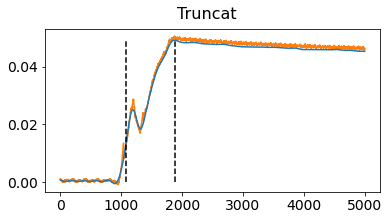


6mLBOPP12 - Trial07
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.051 (bar) in 0.805 (sec)



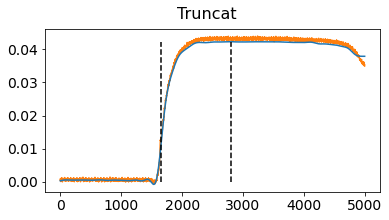


6mLBOPP12 - Trial08
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.044 (bar) in 1.148 (sec)



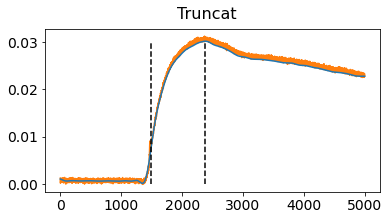


6mLBOPP12 - Trial11
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.031 (bar) in 0.894 (sec)



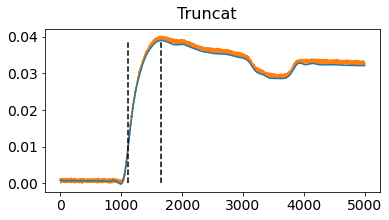


6mLBOPP12 - Trial12
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.040 (bar) in 0.545 (sec)



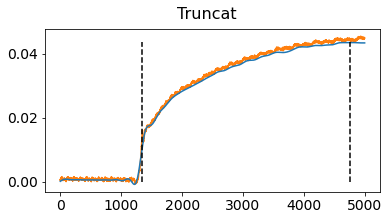


6mLBOPP16 - Trial04
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.045 (bar) in 3.412 (sec)



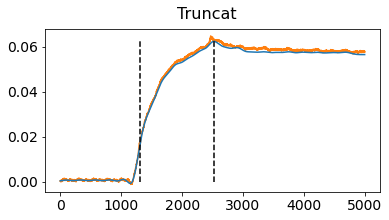


6mLBOPP16 - Trial05
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.065 (bar) in 1.221 (sec)



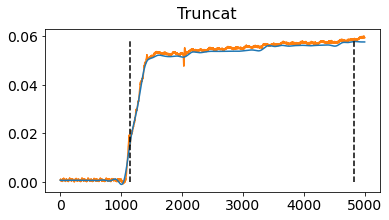


6mLBOPP16 - Trial06
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.060 (bar) in 3.694 (sec)



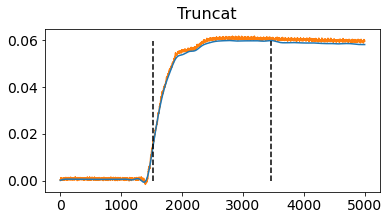


6mLBOPP16 - Trial07
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.062 (bar) in 1.931 (sec)



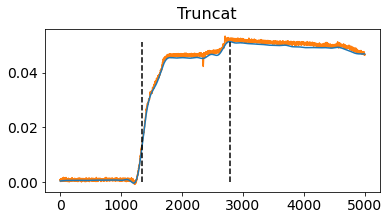


6mLBOPP16 - Trial08
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.053 (bar) in 1.439 (sec)



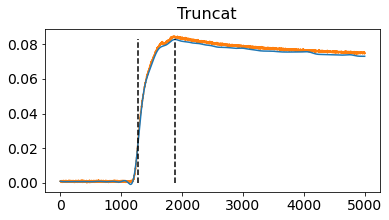


BOPP16ShiftedU7kV - Trial01
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.085 (bar) in 0.614 (sec)



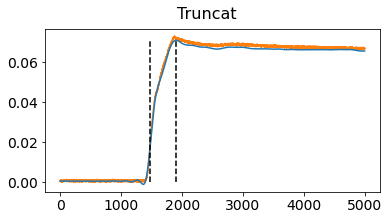


BOPP16ShiftedU7kV - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.428 (sec)



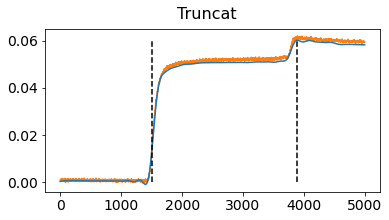


BOPP16ShiftedU7kV - Trial03
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.062 (bar) in 2.383 (sec)



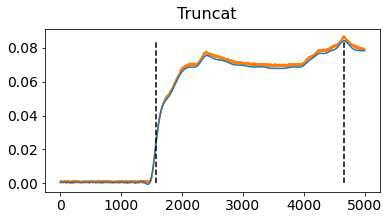


BOPP16ShiftedU7kV - Trial04
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.087 (bar) in 3.096 (sec)



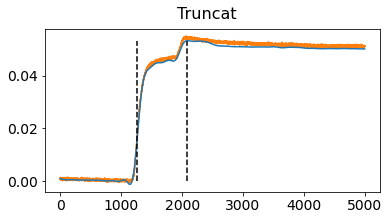


BOPP16ShiftedU7kV - Trial05
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.055 (bar) in 0.835 (sec)



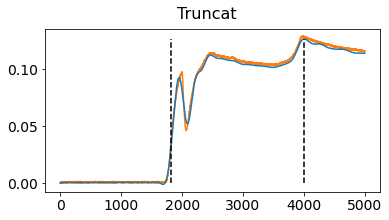


L0Ws16ShiftedU9kV - Trial01
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.129 (bar) in 2.188 (sec)



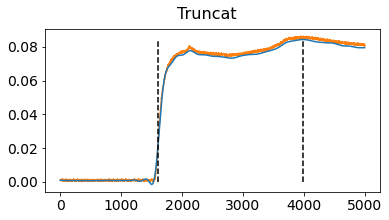


L0Ws16ShiftedU9kV - Trial02
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.086 (bar) in 2.378 (sec)



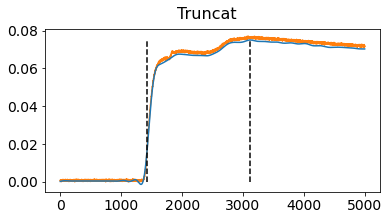


L0Ws16ShiftedU9kV - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.077 (bar) in 1.689 (sec)



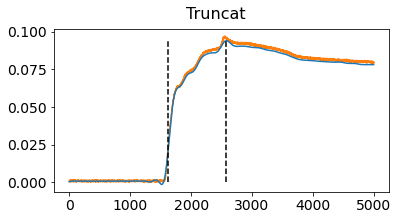


L0Ws16ShiftedU9kV - Trial04
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.097 (bar) in 0.952 (sec)



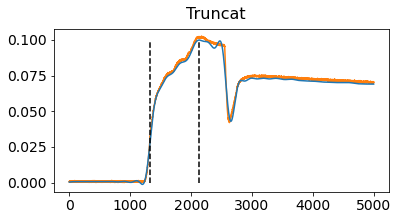


L0Ws16ShiftedU9kV - Trial05
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 0.813 (sec)



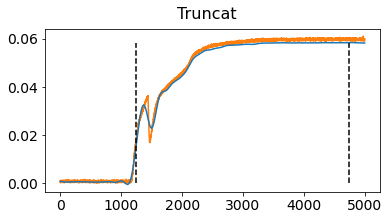


L0Ws16NoShift - Trial01
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.061 (bar) in 3.510 (sec)



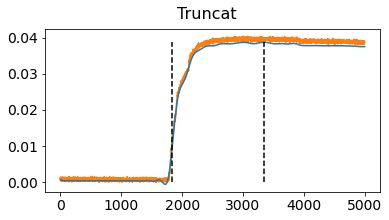


L0Ws16NoShift - Trial02
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.040 (bar) in 1.513 (sec)



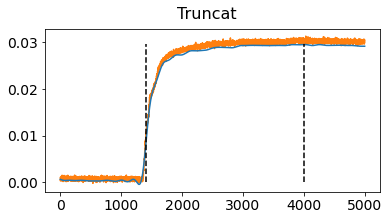


L0Ws16NoShift - Trial03
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 2.605 (sec)



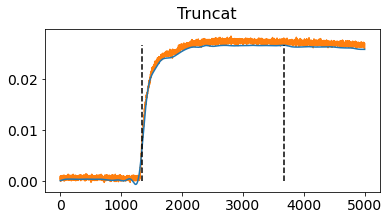


L0Ws16NoShift - Trial04
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.028 (bar) in 2.324 (sec)



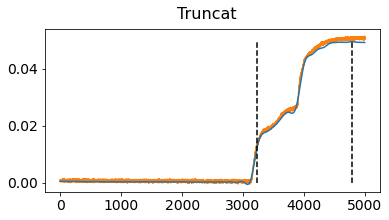


L0Ws16NoShift - Trial05
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.051 (bar) in 1.561 (sec)



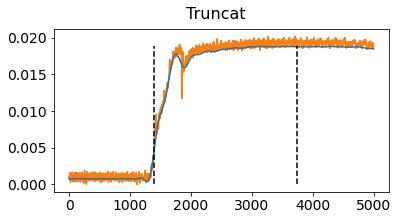


6mLL0Ws12SoftTube - Trial06
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.020 (bar) in 2.342 (sec)



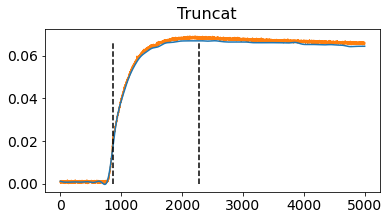


6mLL0Ws12SoftTube - Trial07
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.069 (bar) in 1.414 (sec)



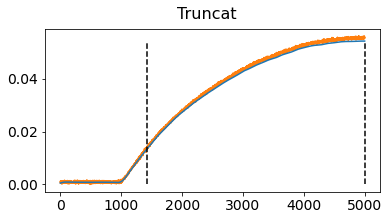


6mLL0Ws12SoftTube - Trial08
Avg. Pressure of zipping = 0.042 (bar), Max. P. = 0.056 (bar) in 3.570 (sec)



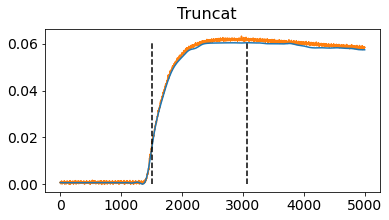


6mLL0Ws12SoftTube - Trial09
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.063 (bar) in 1.561 (sec)



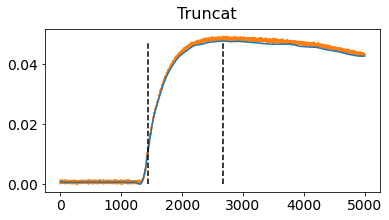


6mLL0Ws12SoftTube - Trial10
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.049 (bar) in 1.229 (sec)



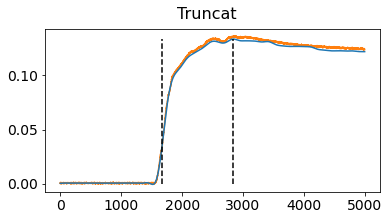


Mylar16 - Trial01
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.136 (bar) in 1.174 (sec)



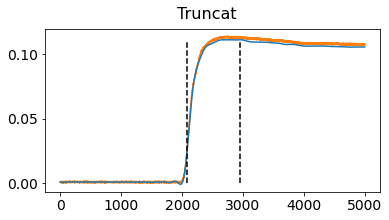


Mylar16 - Trial02
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.114 (bar) in 0.863 (sec)



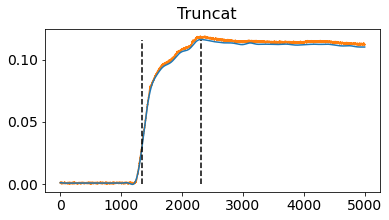


Mylar16 - Trial03
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.119 (bar) in 0.973 (sec)



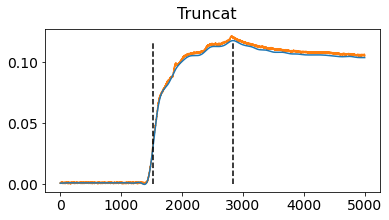


Mylar16 - Trial04
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.121 (bar) in 1.318 (sec)



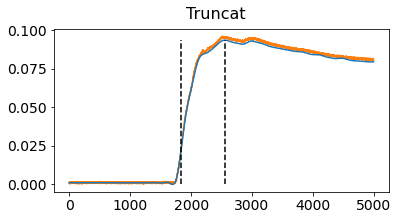


Mylar16 - Trial05
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.096 (bar) in 0.715 (sec)



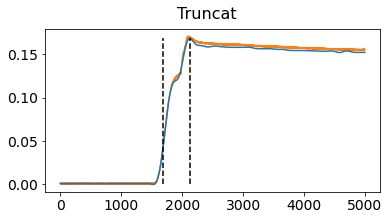


Mylar16NoShift - Trial01
Avg. Pressure of zipping = 0.122 (bar), Max. P. = 0.171 (bar) in 0.437 (sec)



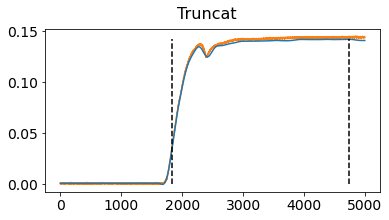


Mylar16NoShift - Trial02
Avg. Pressure of zipping = 0.136 (bar), Max. P. = 0.145 (bar) in 2.904 (sec)



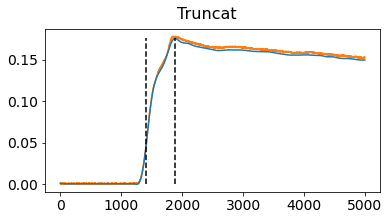


Mylar16NoShift - Trial03
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.178 (bar) in 0.481 (sec)



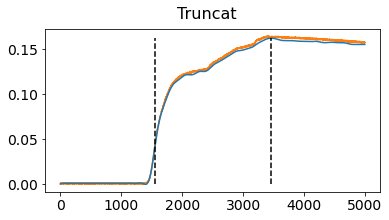


Mylar16NoShift - Trial04
Avg. Pressure of zipping = 0.132 (bar), Max. P. = 0.165 (bar) in 1.914 (sec)



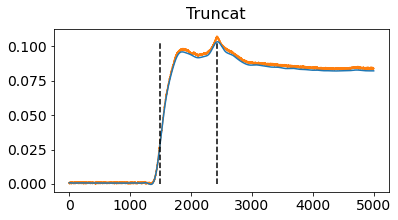


Mylar16NoShift - Trial05
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.108 (bar) in 0.950 (sec)



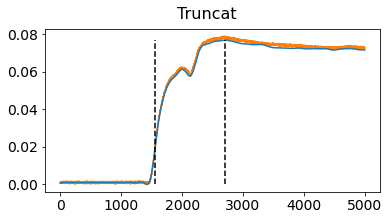


BOPP16 - Trial01
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.079 (bar) in 1.150 (sec)



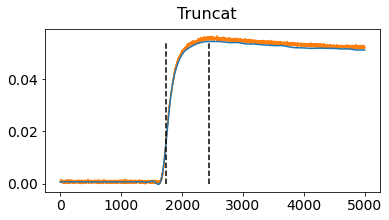


BOPP16 - Trial02
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.057 (bar) in 0.718 (sec)



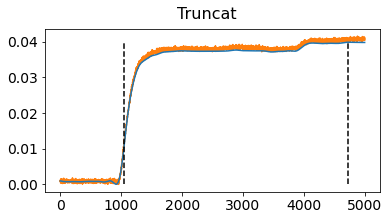


BOPP16 - Trial03
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.042 (bar) in 3.689 (sec)



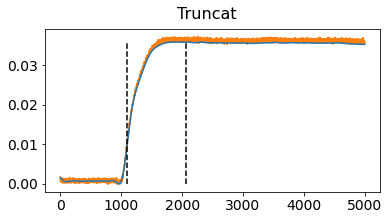


BOPP16 - Trial04
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.037 (bar) in 0.973 (sec)



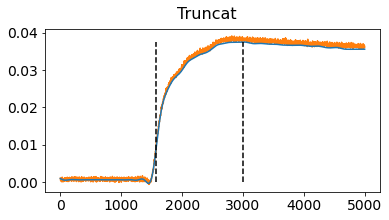


BOPP16 - Trial05
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.039 (bar) in 1.423 (sec)



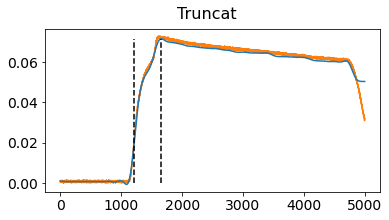


BOPP20 - Trial01
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.453 (sec)



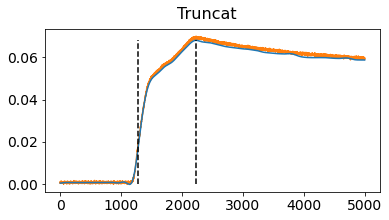


BOPP20 - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.070 (bar) in 0.952 (sec)



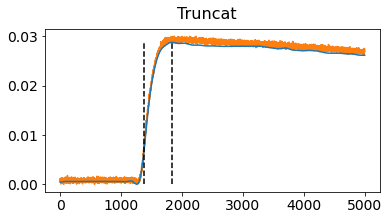


BOPP20 - Trial03
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.030 (bar) in 0.455 (sec)



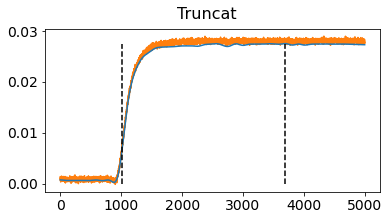


BOPP20 - Trial04
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.029 (bar) in 2.673 (sec)



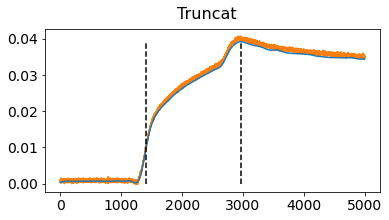


BOPP20 - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.041 (bar) in 1.552 (sec)



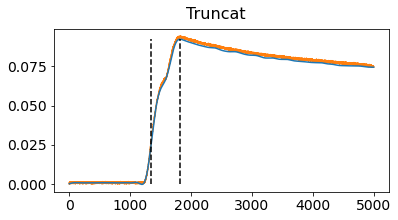


BOPP16U9kV - Trial01
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.094 (bar) in 0.483 (sec)



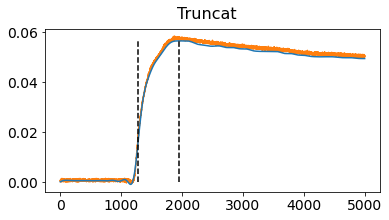


BOPP16U9kV - Trial02
Avg. Pressure of zipping = 0.047 (bar), Max. P. = 0.058 (bar) in 0.673 (sec)



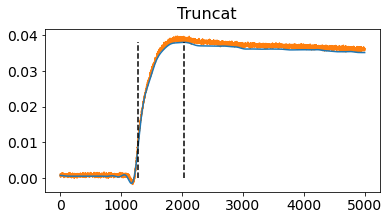


BOPP16U9kV - Trial03
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.040 (bar) in 0.747 (sec)



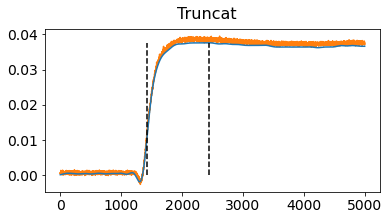


BOPP16U9kV - Trial04
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.039 (bar) in 1.028 (sec)



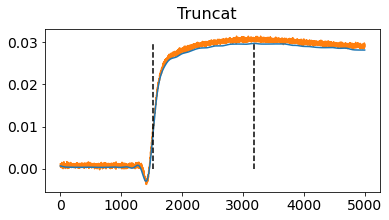


BOPP16U9kV - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 1.661 (sec)



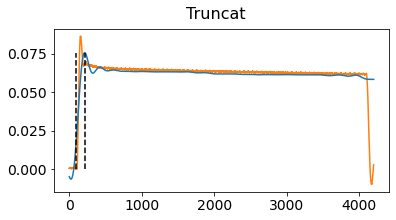


MLSi16SB7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.086 (bar) in 0.115 (sec)



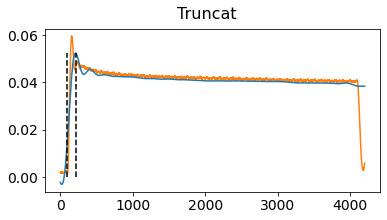


MLSi16SB7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)



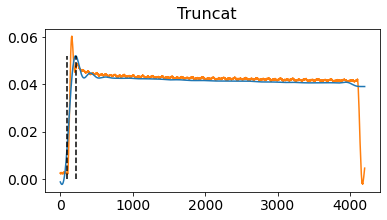


MLSi16SB7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)



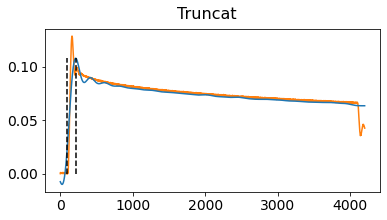


MLSi16SB7kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.129 (bar) in 0.113 (sec)



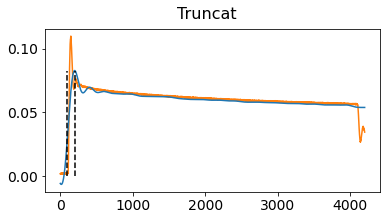


MLSi16SB7kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.110 (bar) in 0.112 (sec)



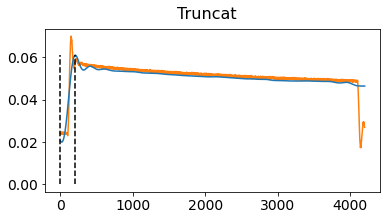


MLSi16SB7kV - Trial05 - Seg3
Avg. Pressure of zipping = 0.040 (bar), Max. P. = 0.070 (bar) in 0.207 (sec)



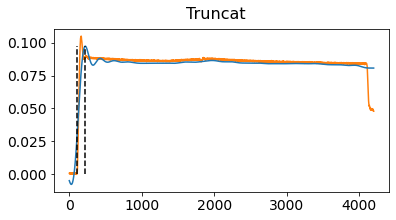


MLSi16CB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.105 (bar) in 0.118 (sec)



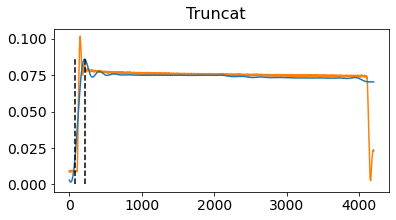


MLSi16CB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.102 (bar) in 0.126 (sec)



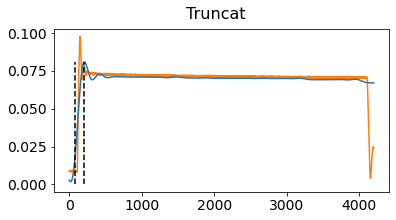


MLSi16CB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.098 (bar) in 0.125 (sec)



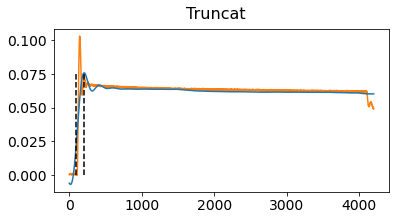


MLSi16CB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.114 (sec)



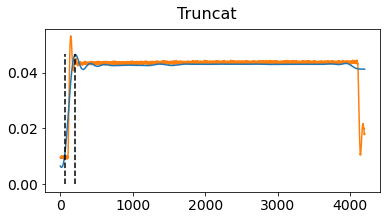


MLSi16CB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)



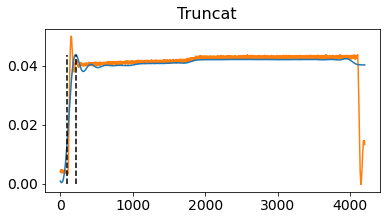


MLSi16CB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.050 (bar) in 0.126 (sec)



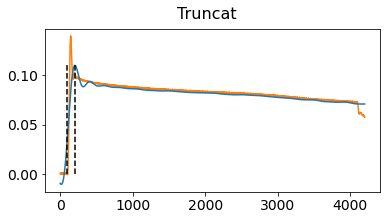


MLSi20SB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.139 (bar) in 0.113 (sec)



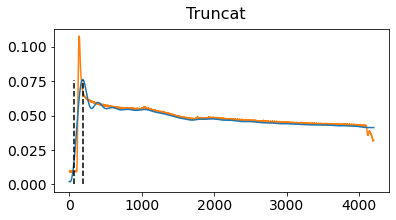


MLSi20SB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.108 (bar) in 0.115 (sec)



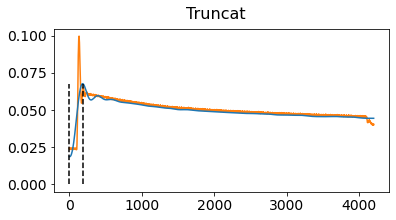


MLSi20SB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.100 (bar) in 0.184 (sec)



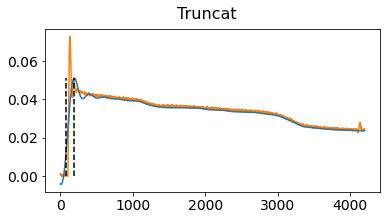


MLSi20SB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.073 (bar) in 0.112 (sec)



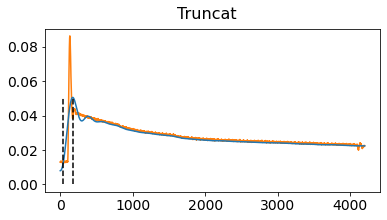


MLSi20SB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.086 (bar) in 0.130 (sec)



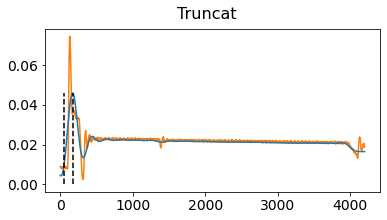


MLSi20SB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.075 (bar) in 0.112 (sec)



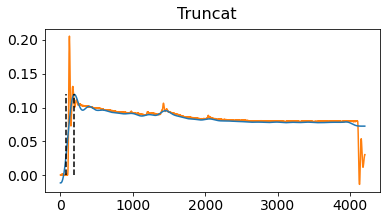


MLSi20B7kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.205 (bar) in 0.114 (sec)



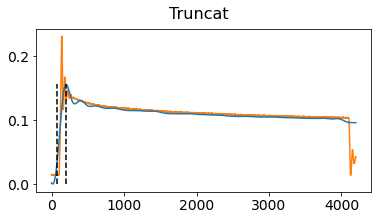


MLSi20B7kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.231 (bar) in 0.120 (sec)



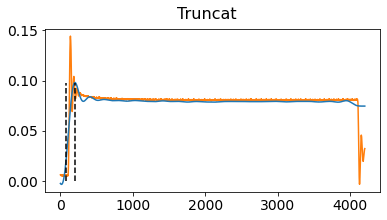


MLSi20B7kV - Trial03 - Seg3
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.144 (bar) in 0.117 (sec)



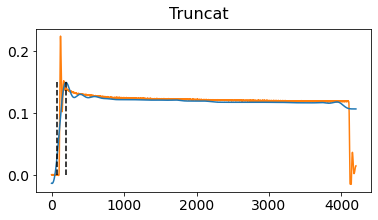


MLSi20B7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.113 (bar), Max. P. = 0.224 (bar) in 0.118 (sec)



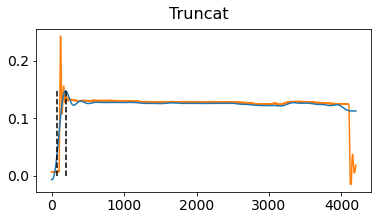


MLSi20B7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.243 (bar) in 0.118 (sec)



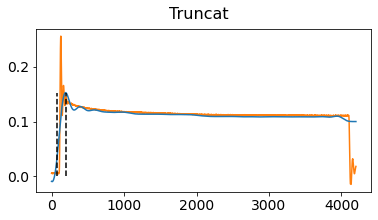


MLSi20B7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.114 (bar), Max. P. = 0.256 (bar) in 0.115 (sec)



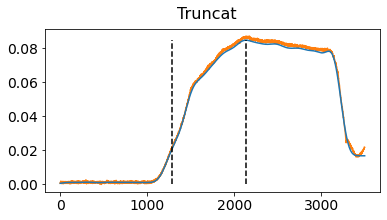


Tube6mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.087 (bar) in 0.845 (sec)



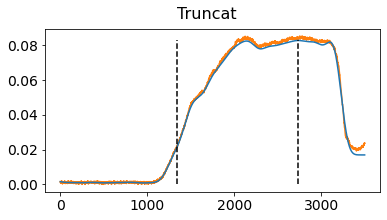


Tube6mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.085 (bar) in 1.400 (sec)



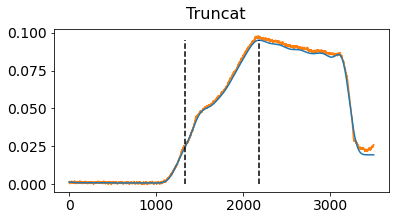


Tube6mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.098 (bar) in 0.859 (sec)



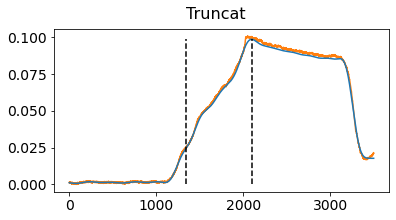


Tube6mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.101 (bar) in 0.751 (sec)



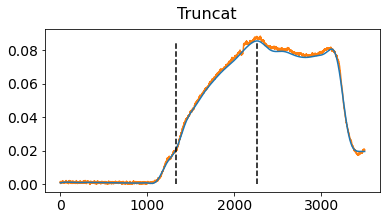


Tube6mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.088 (bar) in 0.927 (sec)



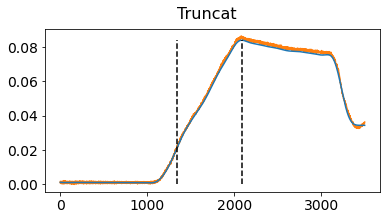


MedTubePressBalloon - Trial01
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.086 (bar) in 0.746 (sec)



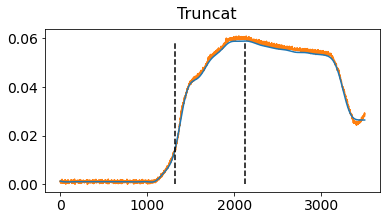


MedTubePressBalloon - Trial02
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.061 (bar) in 0.807 (sec)



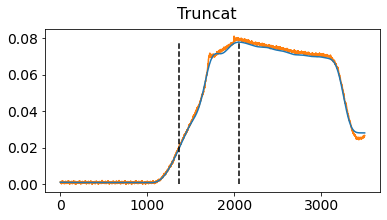


MedTubePressBalloon - Trial03
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.081 (bar) in 0.693 (sec)



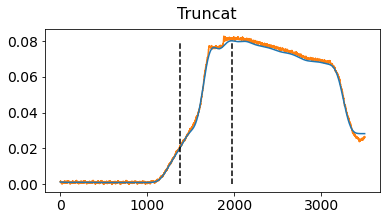


MedTubePressBalloon - Trial04
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.083 (bar) in 0.596 (sec)



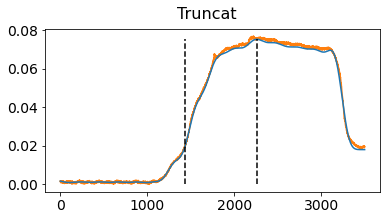


MedTubePressBalloon - Trial05
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.077 (bar) in 0.831 (sec)



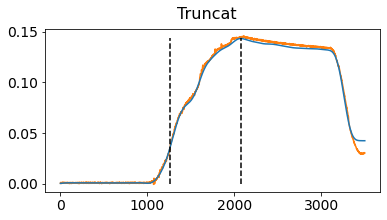


FR3Tube8mm - Trial01
Avg. Pressure of zipping = 0.107 (bar), Max. P. = 0.146 (bar) in 0.814 (sec)



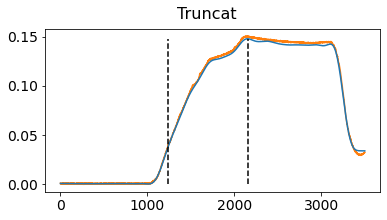


FR3Tube8mm - Trial02
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.150 (bar) in 0.917 (sec)



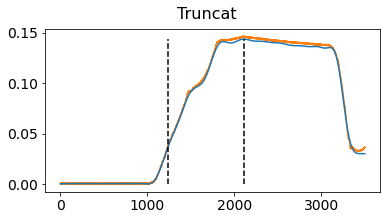


FR3Tube8mm - Trial05
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.147 (bar) in 0.875 (sec)



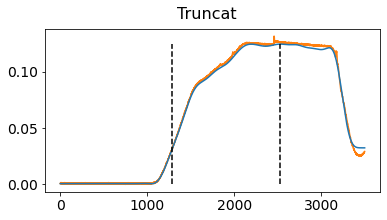


FR3Tube8mm - Trial06
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.132 (bar) in 1.244 (sec)



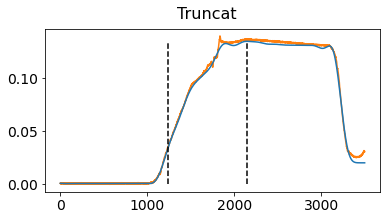


FR3Tube8mm - Trial07
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.140 (bar) in 0.907 (sec)



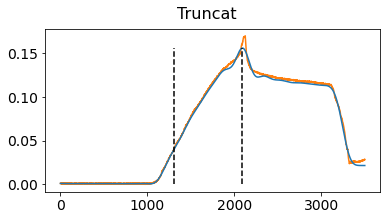


FR3Tube8mm - Trial08
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.170 (bar) in 0.792 (sec)



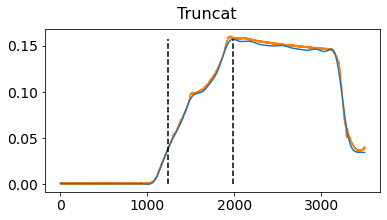


FR3Tube8mm - Trial09
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.160 (bar) in 0.744 (sec)



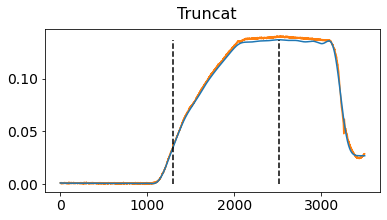


FR3Tube8mm - Trial10
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.140 (bar) in 1.220 (sec)



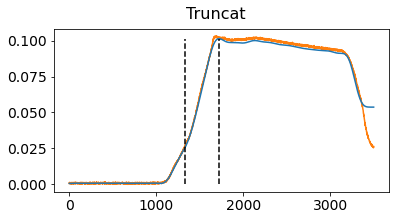


FR3MedTube - Trial01
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.103 (bar) in 0.392 (sec)



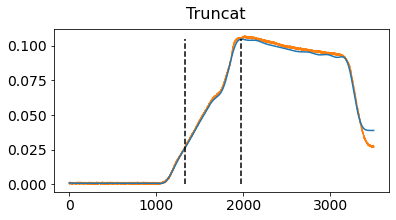


FR3MedTube - Trial02
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.107 (bar) in 0.649 (sec)



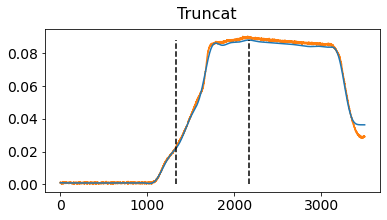


FR3MedTube - Trial03
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.091 (bar) in 0.836 (sec)



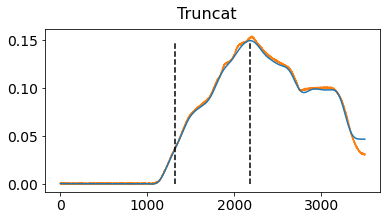


FR3MedTube - Trial04
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.154 (bar) in 0.861 (sec)



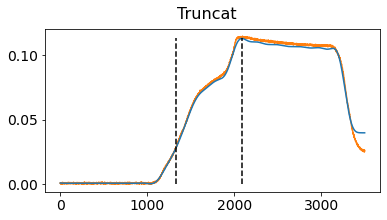


FR3MedTube - Trial05
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.115 (bar) in 0.757 (sec)



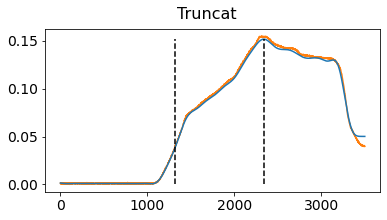


FR3MedTube - Trial06
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.155 (bar) in 1.022 (sec)



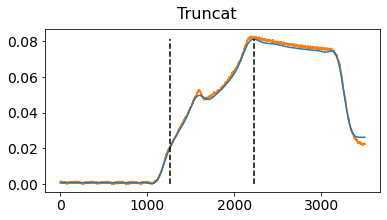


FR3MedTube - Trial07
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.083 (bar) in 0.963 (sec)



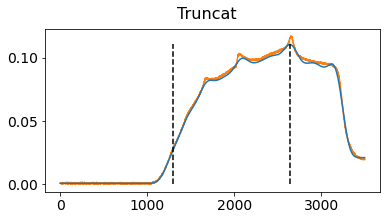


FR3MedTube - Trial08
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.117 (bar) in 1.339 (sec)



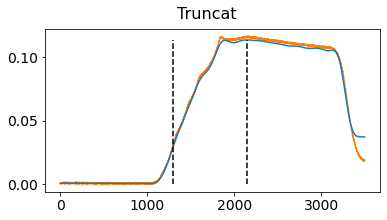


FR3MedTube - Trial09
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.117 (bar) in 0.850 (sec)



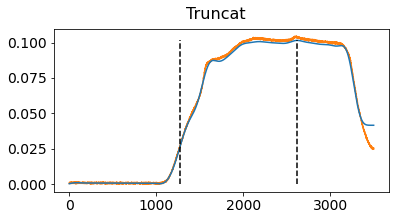


FR3MedTube - Trial10
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.105 (bar) in 1.351 (sec)



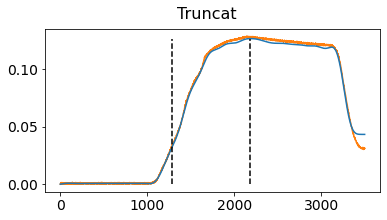


FR3MedTube - Trial11
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.129 (bar) in 0.904 (sec)



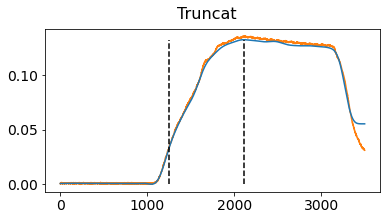


FR3MedTube - Trial12
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.136 (bar) in 0.859 (sec)



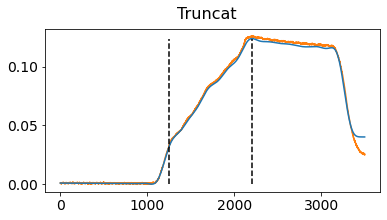


FR3MedTube - Trial13
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.126 (bar) in 0.959 (sec)



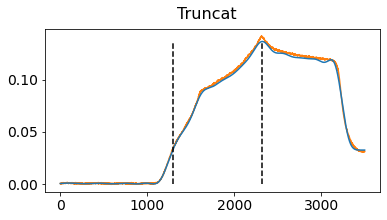


FR3MedTube - Trial14
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.142 (bar) in 1.022 (sec)



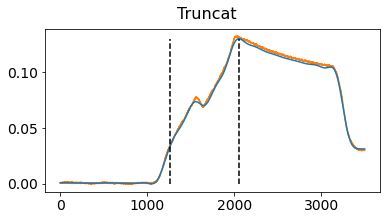


FR3MedTube - Trial15
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.132 (bar) in 0.797 (sec)



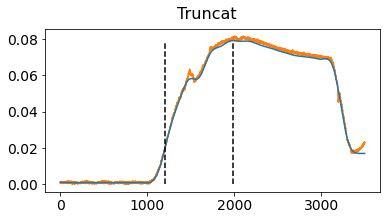


PressBalloon2 - Trial01
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.082 (bar) in 0.782 (sec)



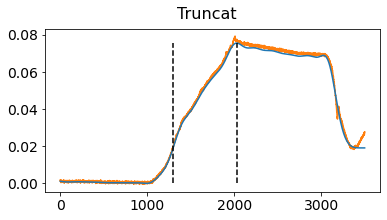


PressBalloon2 - Trial02
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.079 (bar) in 0.733 (sec)



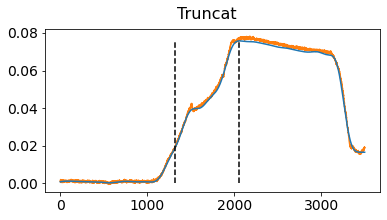


PressBalloon2 - Trial03
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.078 (bar) in 0.737 (sec)



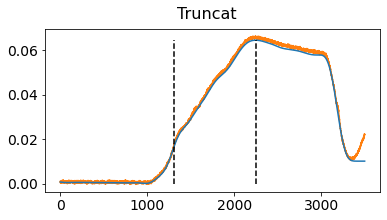


PressBalloon2 - Trial04
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.066 (bar) in 0.943 (sec)



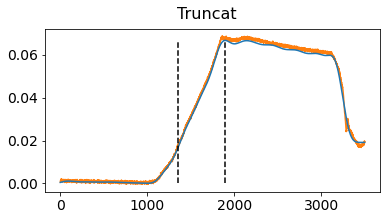


PressBalloon2 - Trial05
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.069 (bar) in 0.542 (sec)



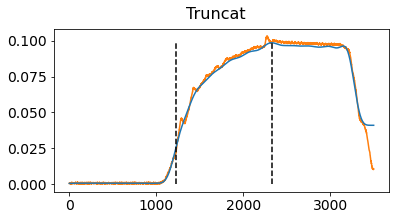


SiMedTube - Trial01
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 1.104 (sec)



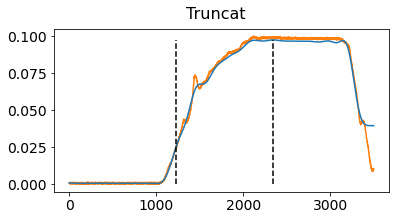


SiMedTube - Trial02
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.100 (bar) in 1.123 (sec)



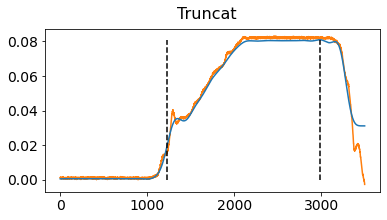


SiMedTube - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.083 (bar) in 1.752 (sec)



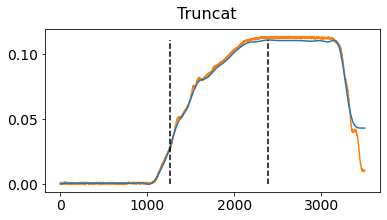


SiMedTube - Trial04
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.114 (bar) in 1.136 (sec)



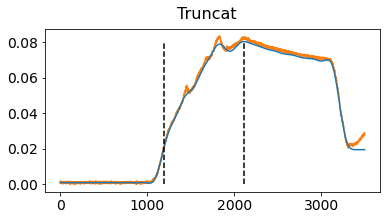


Tube8mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.083 (bar) in 0.922 (sec)



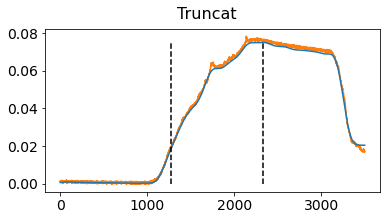


Tube8mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.078 (bar) in 1.057 (sec)



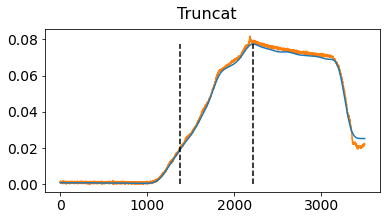


Tube8mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.082 (bar) in 0.836 (sec)



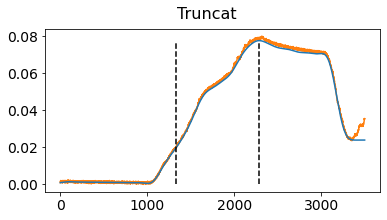


Tube8mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.080 (bar) in 0.958 (sec)



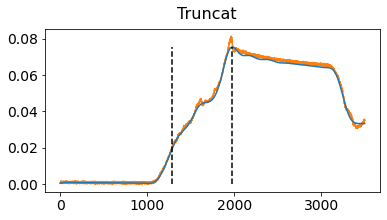


Tube8mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.081 (bar) in 0.697 (sec)



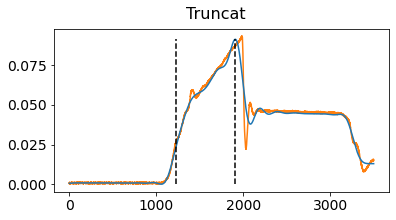


SiMedTube - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.093 (bar) in 0.685 (sec)



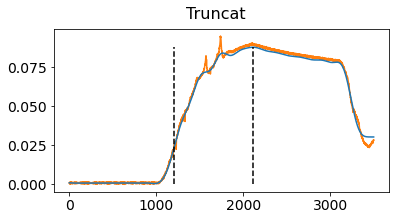


Pressure - Trial01
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.095 (bar) in 0.914 (sec)



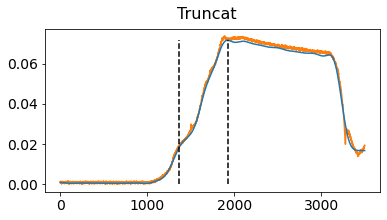


Pressure - Trial02
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.074 (bar) in 0.561 (sec)



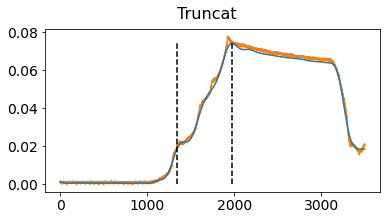


Pressure - Trial03
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.078 (bar) in 0.634 (sec)



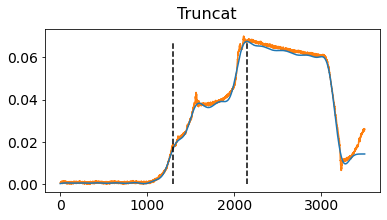


Pressure - Trial04
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.070 (bar) in 0.848 (sec)



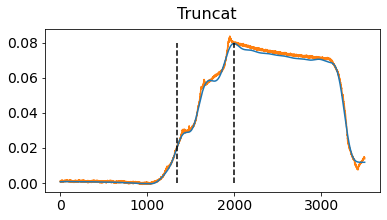


Pressure - Trial05
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.084 (bar) in 0.657 (sec)



In [139]:
pressData = []
''' Process measurement data saved as individual csv files by trial '''
for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data driven by reversed polarity from bipolar wearable controller '''                
for root, directories, files in walk(".\data\ValidData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)
            names = re.split('U6900V', names)[0] # Shorten the names

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
            data = (data[:,1] - calib[1]) * calib[0] # Unit conversion 
            
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

            
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv") 



In [79]:
# ax,_=aPlot()

# for i in range(5):
#     ax.plot(sigData.loc[sigData['CondiName'] == 'Mylar16NoShift','PressSig_kPa'].iloc[i])

In [126]:
sigData.head()

,CondiName,PressSig_kPa,SegIndex
0,6mLBOPP12,"[0.6934683875862988, 0.7062986629823137, 0.704...","[1349, 1692]"
1,6mLBOPP12,"[0.9468663266575907, 0.9276209135635686, 0.937...","[1075, 1877]"
2,6mLBOPP12,"[0.7929030219054134, 0.8025257284524245, 0.836...","[1654, 2799]"
3,6mLBOPP12,"[0.42884395754349397, 0.3695039338369256, 0.32...","[1497, 2384]"
4,6mLBOPP12,"[0.44488180178851244, 0.44327801736401057, 0.4...","[1119, 1660]"


In [56]:
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.head()

,CondiName,PFull_Pa,P1Expan_Pa,P2Expan_Pa,P1Cell_Pa,EsFull_J,Es1Expan_J,Es2Expan_J,Es1Cell_J,dVFull_m3,dV1Expan_m3,dV2Expan_m3,dV1Cell_m3,lossFactor
0,6mLBOPP12,18309.576272,18437.072107,18536.991472,20489.240375,0.219877,0.167974,0.118352,0.006369,0.000006,0.000005,0.000003,1.554328e-07,7.467550e+08
1,6mLBOPP16,18369.100124,18430.752923,18478.254245,19282.763638,0.220229,0.169256,0.119807,0.006970,0.000006,0.000005,0.000003,1.807397e-07,7.467550e+08
2,6mLL0Ws12SoftTube,16571.600847,16686.369396,16776.314299,18533.679736,0.199006,0.152024,0.107111,0.005761,0.000006,0.000005,0.000003,1.554328e-07,7.467550e+08
3,BOPP16ShiftedU7kV,9209.457039,9271.051466,9327.935659,9663.089772,0.110574,0.077282,0.050529,0.004557,0.000006,0.000004,0.000003,2.357996e-07,7.467550e+08
4,L0Ws16ShiftedU9kV,12467.059846,12550.068104,12626.728575,13078.401894,0.149687,0.104615,0.068399,0.006168,0.000006,0.000004,0.000003,2.357996e-07,7.467550e+08


5.906348629743552e-06
1.1130263906042823
[1346 1692]
6mLBOPP12 inital air volume = 5.906349 mL


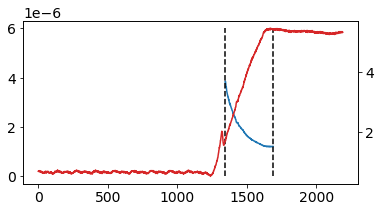

5.802879514110593e-06
1.0857620553877507
[1072 1877]
6mLBOPP12 inital air volume = 5.802880 mL


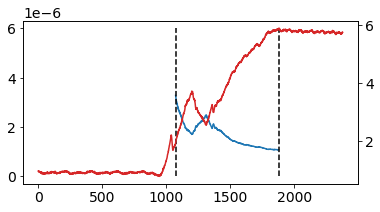

6.298891032918063e-06
1.2172723781969021
[1651 2799]
6mLBOPP12 inital air volume = 6.298891 mL


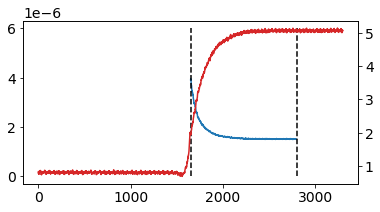

6.205435619144481e-06
0.830760331891957
[1490 2384]
6mLBOPP12 inital air volume = 6.205436 mL


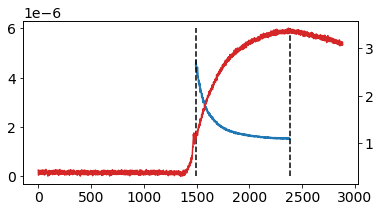

6.064882055039443e-06
0.999157696464651
[1115 1660]
6mLBOPP12 inital air volume = 6.064882 mL


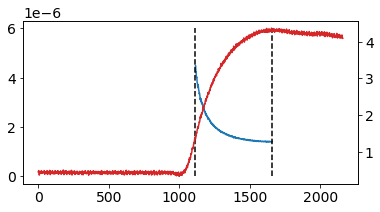

7.054149898768557e-06
1.5877465802568287
[1347 4759]
6mLBOPP16 inital air volume = 7.054150 mL


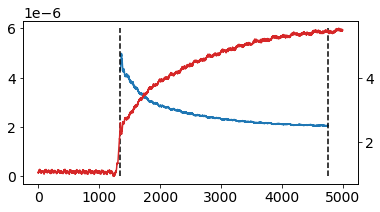

6.2457179412649205e-06
1.7112379809434715
[1303 2524]
6mLBOPP16 inital air volume = 6.245718 mL


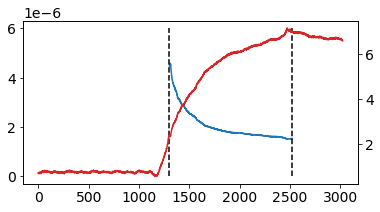

6.624156581443126e-06
1.8443520881771245
[1137 4831]
6mLBOPP16 inital air volume = 6.624157 mL


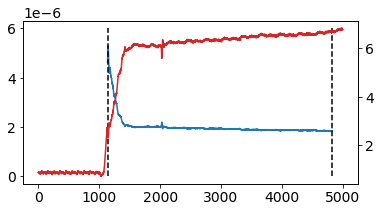

6.29578749962143e-06
1.6743509391799285
[1526 3457]
6mLBOPP16 inital air volume = 6.295787 mL


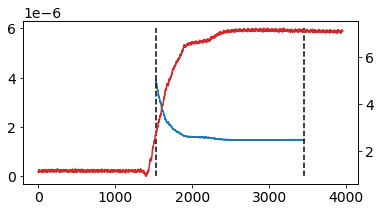

6.020463415861965e-06
1.2685934797809615
[1342 2781]
6mLBOPP16 inital air volume = 6.020463 mL


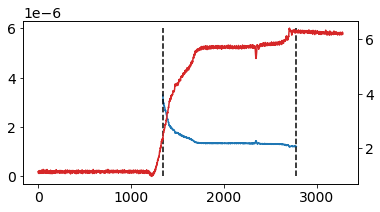

5.601410744071079e-06
2.1667127575019958
[1271 1885]
BOPP16ShiftedU7kV inital air volume = 5.601411 mL


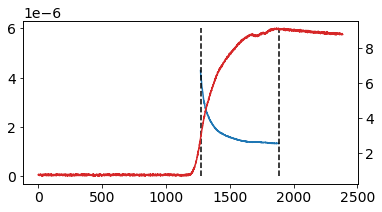

5.662310819009609e-06
1.922937524977715
[1475 1903]
BOPP16ShiftedU7kV inital air volume = 5.662311 mL


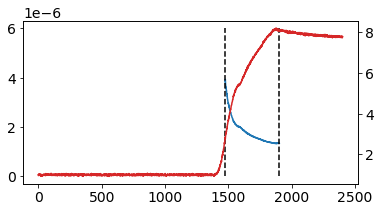

5.684437174426351e-06
1.650294172812401
[1510 3893]
BOPP16ShiftedU7kV inital air volume = 5.684437 mL


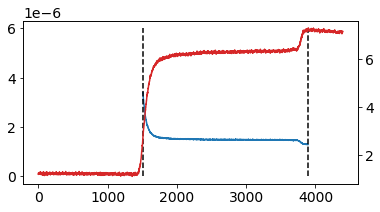

5.703773606674858e-06
2.3415252597726974
[1566 4662]
BOPP16ShiftedU7kV inital air volume = 5.703774 mL


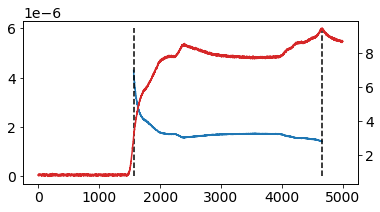

5.640371266004874e-06
1.438594628778157
[1253 2088]
BOPP16ShiftedU7kV inital air volume = 5.640371 mL


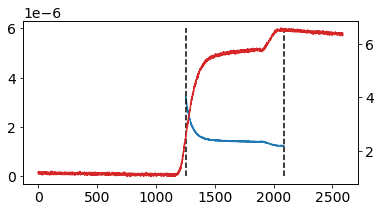

5.826671423107166e-06
3.6790814698072376
[1819 4007]
L0Ws16ShiftedU9kV inital air volume = 5.826671 mL


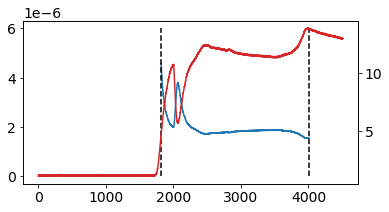

5.621599335898953e-06
2.2324679189065715
[1605 3983]
L0Ws16ShiftedU9kV inital air volume = 5.621599 mL


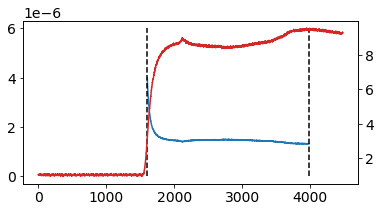

5.604221774511369e-06
1.975862410986276
[1432 3121]
L0Ws16ShiftedU9kV inital air volume = 5.604222 mL


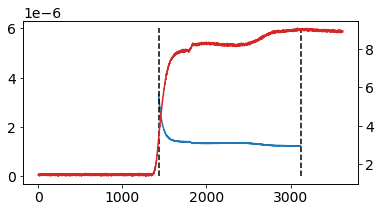

5.689573337280404e-06
2.593319414419487
[1629 2581]
L0Ws16ShiftedU9kV inital air volume = 5.689573 mL


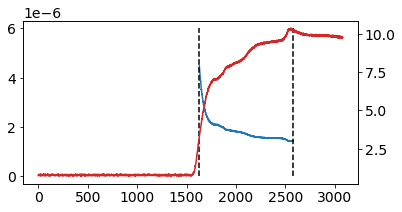

5.67366402786417e-06
2.723225952804137
[1319 2132]
L0Ws16ShiftedU9kV inital air volume = 5.673664 mL


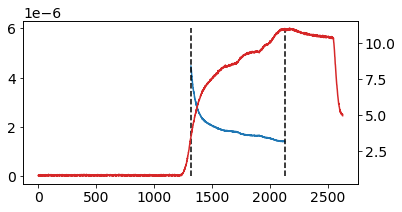

6.057937810497395e-06
1.6823698613024378
[1240 4750]
L0Ws16NoShift inital air volume = 6.057938 mL


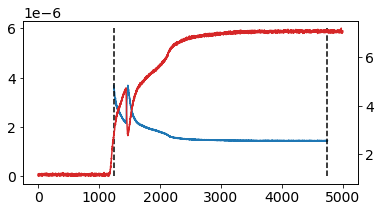

6.097592079269116e-06
1.1322718036983042
[1838 3351]
L0Ws16NoShift inital air volume = 6.097592 mL


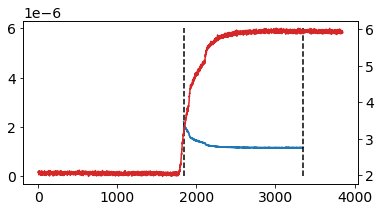

6.203826376042909e-06
0.9141571219660527
[1400 4005]
L0Ws16NoShift inital air volume = 6.203826 mL


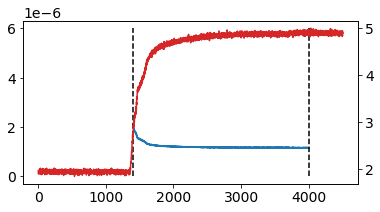

6.084000164811388e-06
0.7906657212794106
[1344 3668]
L0Ws16NoShift inital air volume = 6.084000 mL


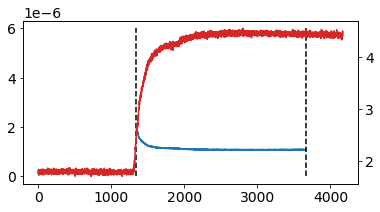

5.820643112522108e-06
1.2637821265074556
[3233 4794]
L0Ws16NoShift inital air volume = 5.820643 mL


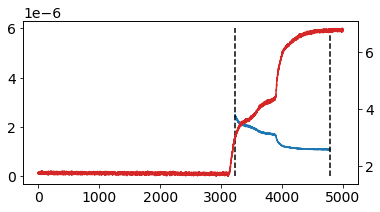

5.977382641450824e-06
0.48113532735055436
[1396 3738]
6mLL0Ws12SoftTube inital air volume = 5.977383 mL


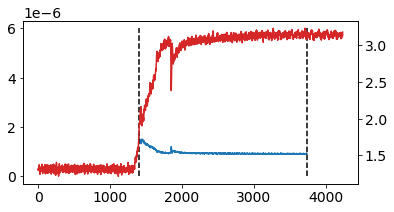

6.387518627439722e-06
1.9854851175332873
[ 862 2276]
6mLL0Ws12SoftTube inital air volume = 6.387519 mL


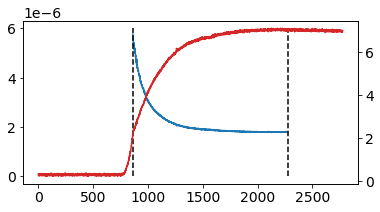

6.022731317648883e-06
1.3680281141000759
[1429 4999]
6mLL0Ws12SoftTube inital air volume = 6.022731 mL


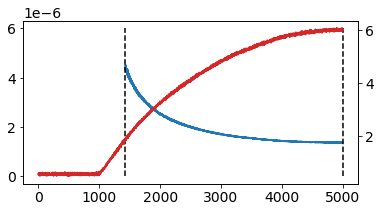

6.159598301282377e-06
1.6486903883878992
[1501 3062]
6mLL0Ws12SoftTube inital air volume = 6.159598 mL


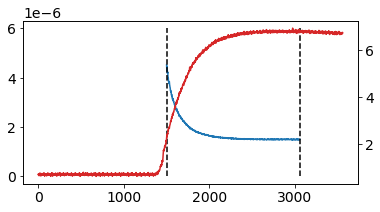

6.17978236436482e-06
1.2942540305729908
[1448 2677]
6mLL0Ws12SoftTube inital air volume = 6.179782 mL


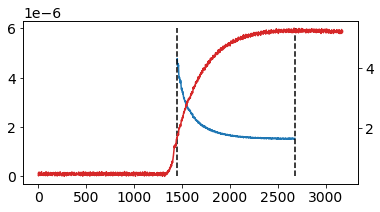

5.505655537059358e-06
3.3021921300493036
[1668 2842]
Mylar16 inital air volume = 5.505656 mL


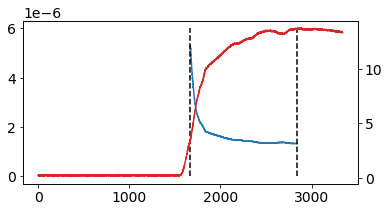

5.458767144569517e-06
2.699169186436609
[2088 2951]
Mylar16 inital air volume = 5.458767 mL


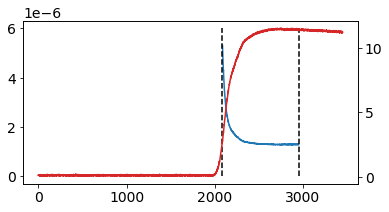

5.577530535757209e-06
3.0022844426674586
[1340 2313]
Mylar16 inital air volume = 5.577531 mL


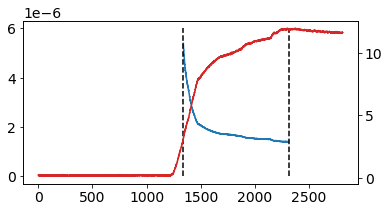

5.685207290783724e-06
3.2380407530692294
[1520 2838]
Mylar16 inital air volume = 5.685207 mL


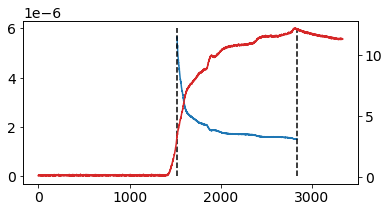

5.5393443685664445e-06
2.3816198703852436
[1841 2556]
Mylar16 inital air volume = 5.539344 mL


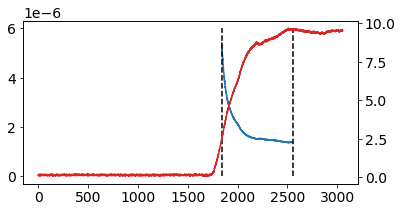

5.90621113217483e-06
4.389557969861556
[1686 2123]
Mylar16NoShift inital air volume = 5.906211 mL


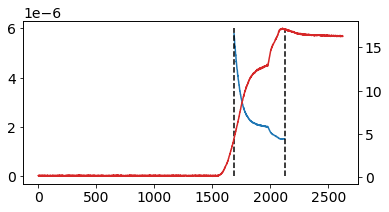

5.893267218483435e-06
3.7031382361747656
[1835 4739]
Mylar16NoShift inital air volume = 5.893267 mL


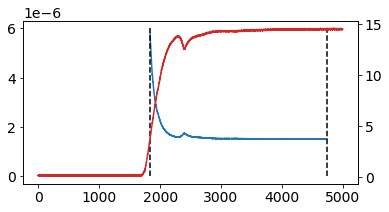

5.797222677169425e-06
4.323802808456981
[1403 1884]
Mylar16NoShift inital air volume = 5.797223 mL


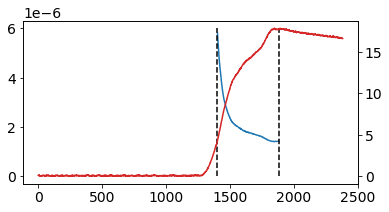

5.957589949400179e-06
4.330217946154988
[1551 3465]
Mylar16NoShift inital air volume = 5.957590 mL


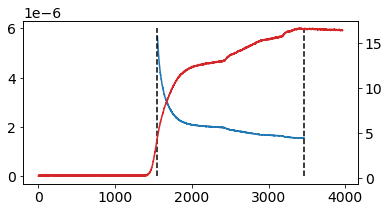

5.9386578402340606e-06
2.801811389604727
[1484 2434]
Mylar16NoShift inital air volume = 5.938658 mL


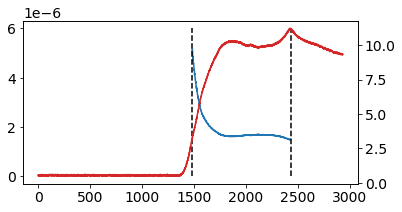

5.953362506915101e-06
2.0736932608808893
[1558 2708]
BOPP16 inital air volume = 5.953363 mL


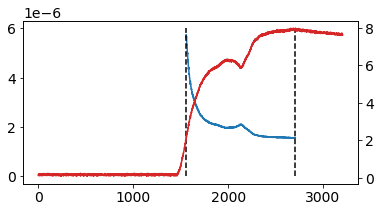

5.950251730036994e-06
1.4802930238152052
[1729 2447]
BOPP16 inital air volume = 5.950252 mL


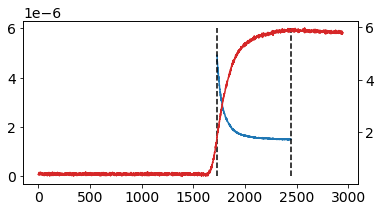

5.905188810796548e-06
1.0665166422937287
[1044 4733]
BOPP16 inital air volume = 5.905189 mL


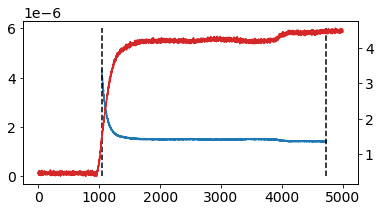

5.893892959590778e-06
0.9526479481540975
[1092 2065]
BOPP16 inital air volume = 5.893893 mL


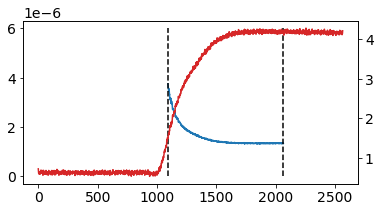

6.019853193582667e-06
1.0568939357467177
[1577 3000]
BOPP16 inital air volume = 6.019853 mL


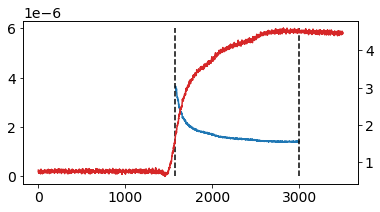

6.1876964836034315e-06
1.8988807586101875
[1207 1660]
BOPP20 inital air volume = 6.187696 mL


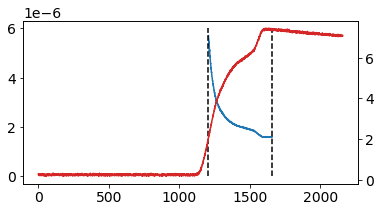

6.167851220670228e-06
1.8090688308380842
[1278 2230]
BOPP20 inital air volume = 6.167851 mL


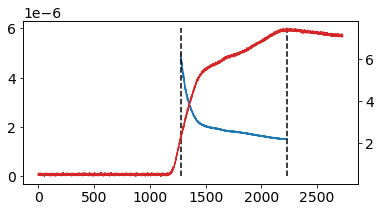

6.060167634497142e-06
0.7361370508463481
[1378 1833]
BOPP20 inital air volume = 6.060168 mL


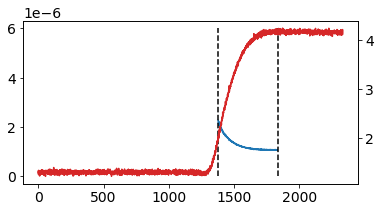

6.225243553995096e-06
0.7682127393363849
[1017 3690]
BOPP20 inital air volume = 6.225244 mL


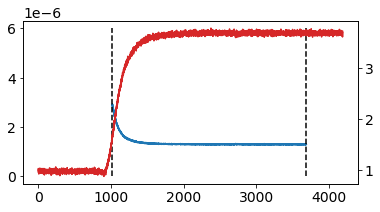

6.113717535144682e-06
1.0248182472566805
[1409 2961]
BOPP20 inital air volume = 6.113718 mL


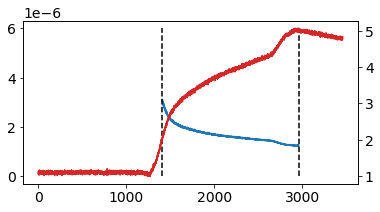

5.932182554409563e-06
2.4473750317898193
[1337 1820]
BOPP16U9kV inital air volume = 5.932183 mL


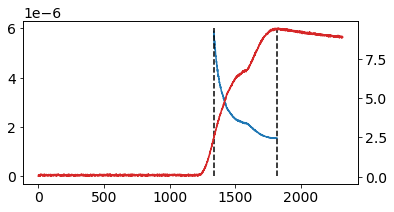

6.059302529125737e-06
1.6069919933508512
[1271 1944]
BOPP16U9kV inital air volume = 6.059303 mL


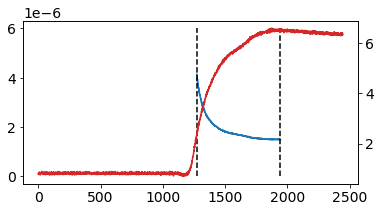

6.0710866483459995e-06
1.1017998996327694
[1282 2029]
BOPP16U9kV inital air volume = 6.071087 mL


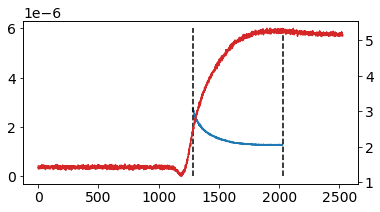

5.8670262580065154e-06
0.9927425587666433
[1417 2445]
BOPP16U9kV inital air volume = 5.867026 mL


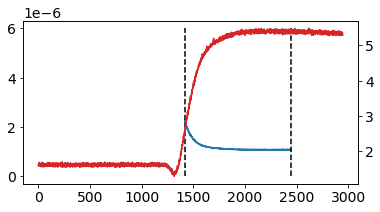

6.119168218683214e-06
0.8884965711740231
[1518 3179]
BOPP16U9kV inital air volume = 6.119168 mL


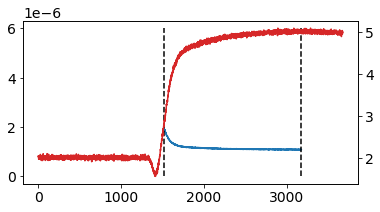

6.09221171748256e-06
2.1667127575019958
[1289 2134]
Tube6mmPressBalloon inital air volume = 6.092212 mL


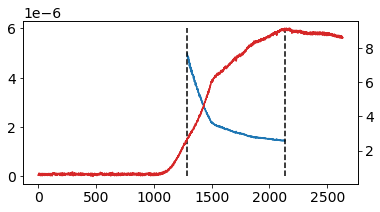

6.119624150686121e-06
2.153882482105981
[1336 2736]
Tube6mmPressBalloon inital air volume = 6.119624 mL


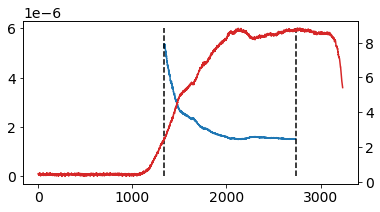

6.158065809239282e-06
2.5099226243453914
[1325 2184]
Tube6mmPressBalloon inital air volume = 6.158066 mL


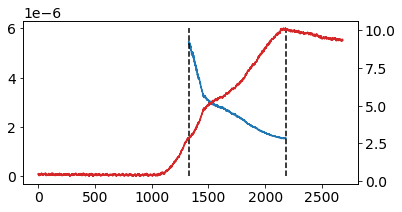

6.115951490436471e-06
2.5419983128354278
[1345 2096]
Tube6mmPressBalloon inital air volume = 6.115951 mL


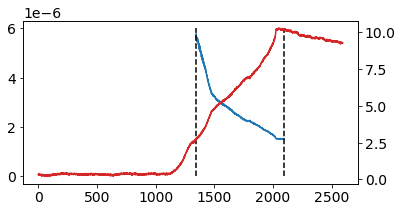

5.9723243182881164e-06
2.0640705543338775
[1335 2262]
Tube6mmPressBalloon inital air volume = 5.972324 mL


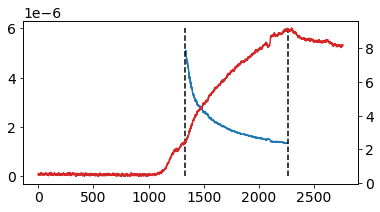

6.097055038679132e-06
2.1570900509549853
[1341 2087]
MedTubePressBalloon inital air volume = 6.097055 mL


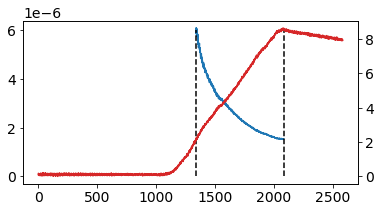

6.025991254060186e-06
1.4658589639946886
[1322 2129]
MedTubePressBalloon inital air volume = 6.025991 mL


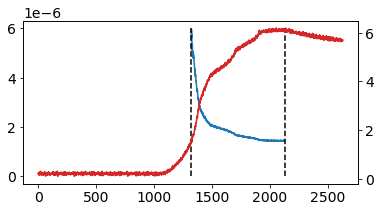

6.112156773378862e-06
2.04001378796635
[1363 2056]
MedTubePressBalloon inital air volume = 6.112157 mL


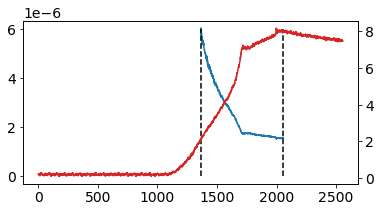

6.126987049222215e-06
2.096146242823915
[1373 1969]
MedTubePressBalloon inital air volume = 6.126987 mL


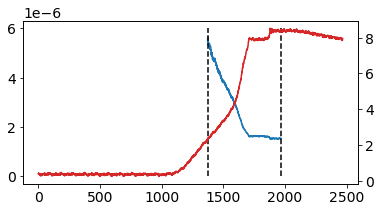

6.114503645403133e-06
1.938975369222734
[1429 2260]
MedTubePressBalloon inital air volume = 6.114504 mL


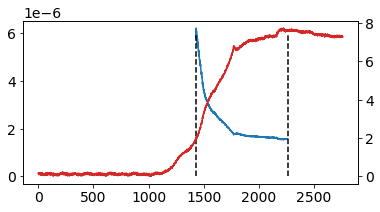

6.060337926110218e-06
1.998315392929302
[1204 1986]
PressBalloon2 inital air volume = 6.060338 mL


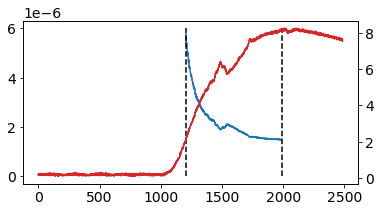

6.045432947779508e-06
1.9277488782512204
[1296 2029]
PressBalloon2 inital air volume = 6.045433 mL


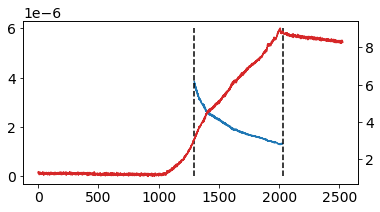

6.109669193325922e-06
1.966239704439265
[1321 2058]
PressBalloon2 inital air volume = 6.109669 mL


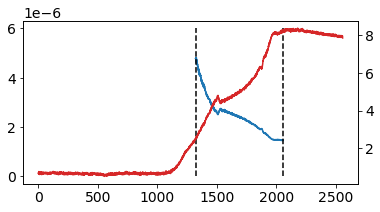

6.131195455398248e-06
1.6839736457269396
[1303 2246]
PressBalloon2 inital air volume = 6.131195 mL


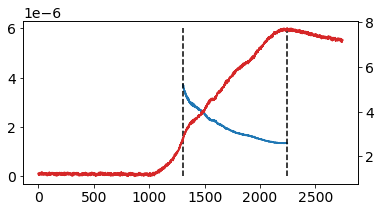

6.145937843615876e-06
1.7577477292540247
[1354 1896]
PressBalloon2 inital air volume = 6.145938 mL


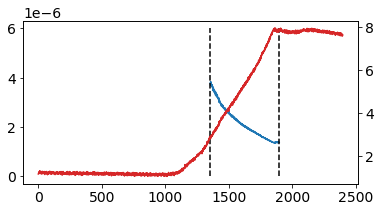

5.802772331753223e-06
2.1811468173225124
[1222 2326]
SiMedTube inital air volume = 5.802772 mL


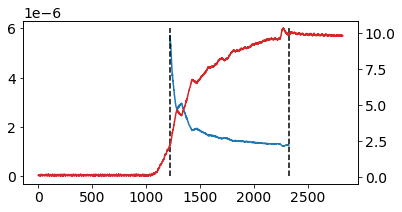

6.003133994698465e-06
2.37841230153624
[1222 2345]
SiMedTube inital air volume = 6.003134 mL


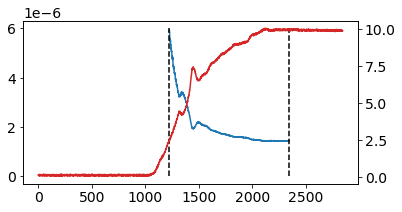

5.718265820077256e-06
1.659916879359412
[1231 2983]
SiMedTube inital air volume = 5.718266 mL


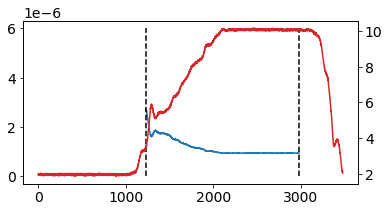

5.976884093521649e-06
2.676716204493583
[1256 2392]
SiMedTube inital air volume = 5.976884 mL


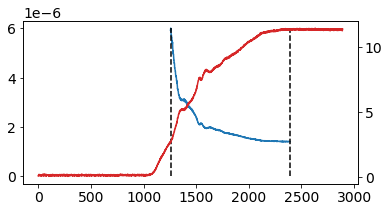

6.048475735511934e-06
2.030391081419339
[1190 2112]
Tube8mmPressBalloon inital air volume = 6.048476 mL


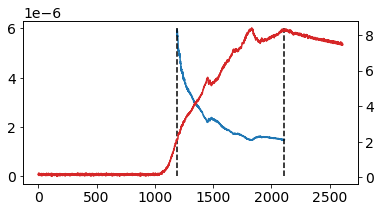

6.0624127572754375e-06
1.9213337405532132
[1274 2331]
Tube8mmPressBalloon inital air volume = 6.062413 mL


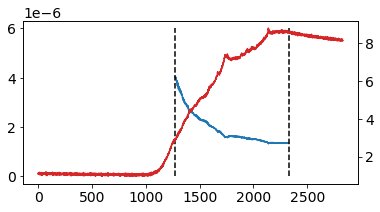

6.093303625722667e-06
2.0384100035418475
[1381 2217]
Tube8mmPressBalloon inital air volume = 6.093304 mL


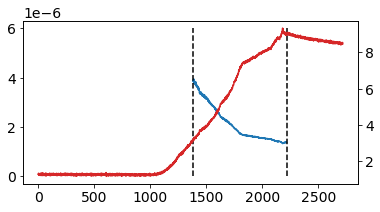

6.0980354755833e-06
1.998315392929302
[1329 2287]
Tube8mmPressBalloon inital air volume = 6.098035 mL


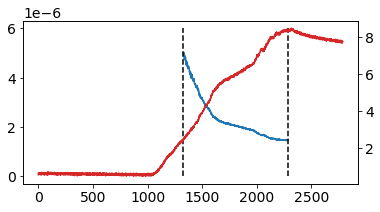

6.061499816683286e-06
1.998315392929302
[1281 1978]
Tube8mmPressBalloon inital air volume = 6.061500 mL


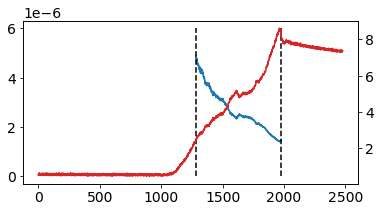

6.374159292721466e-06
2.631810240607532
[1223 1908]
SiMedTube inital air volume = 6.374159 mL


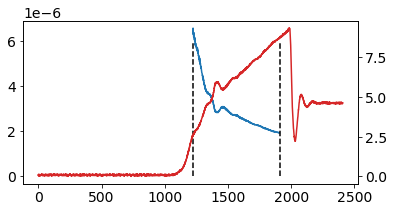

5.8564658390073065e-06
2.0752970453053905
[1198 2112]
Pressure inital air volume = 5.856466 mL


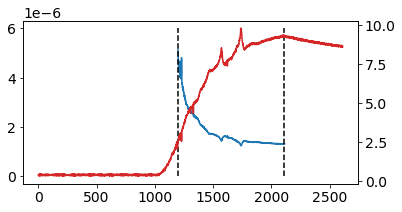

6.118269883940979e-06
1.858786147997641
[1362 1923]
Pressure inital air volume = 6.118270 mL


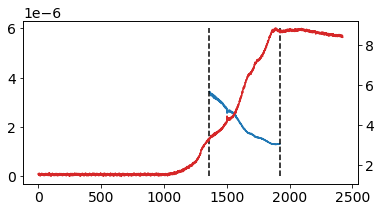

6.152484568120009e-06
1.995107824080298
[1341 1975]
Pressure inital air volume = 6.152485 mL


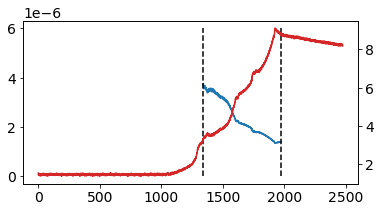

6.2689874177893526e-06
1.8924656209121797
[1297 2145]
Pressure inital air volume = 6.268987 mL


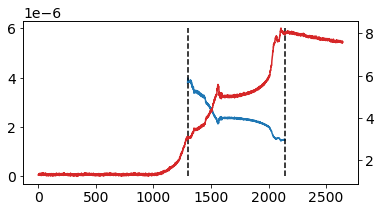

6.032696170839699e-06
2.023975943721331
[1340 1997]
Pressure inital air volume = 6.032696 mL


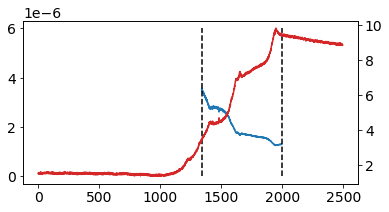

4.172544250742216e-06
0.009622706547011105
[ 98 213]
MLSi16SB7kV inital air volume = 4.172544 mL


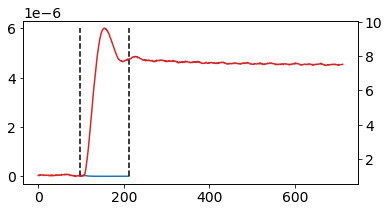

4.320369422888865e-06
0.21009575960974203
[ 93 211]
MLSi16SB7kV inital air volume = 4.320369 mL


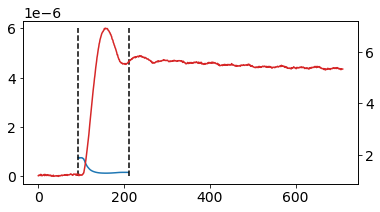

4.345797637976076e-06
0.2469828013732845
[ 94 212]
MLSi16SB7kV inital air volume = 4.345798 mL


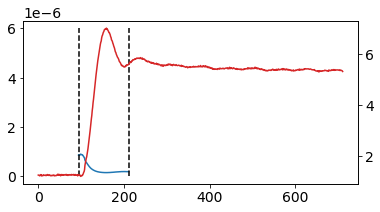

4.1804188367048025e-06
0.038490826188044336
[ 99 212]
MLSi16SB7kV inital air volume = 4.180419 mL


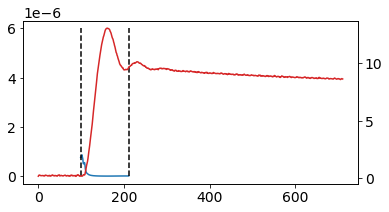

4.23020822919434e-06
0.16198222687468658
[ 86 198]
MLSi16SB7kV inital air volume = 4.230208 mL


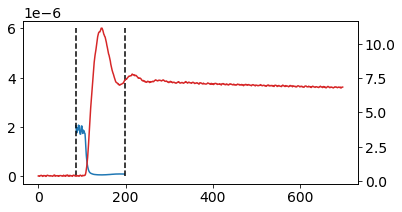

4.411544496064191e-06
0.04811353273505542
[102 220]
MLSi16CB7kV inital air volume = 4.411544 mL


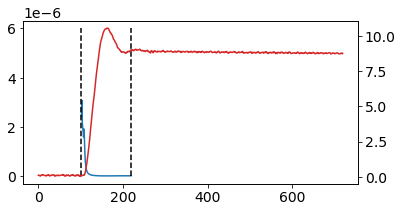

4.830234459017441e-06
0.9253836129375661
[ 85 211]
MLSi16CB7kV inital air volume = 4.830234 mL


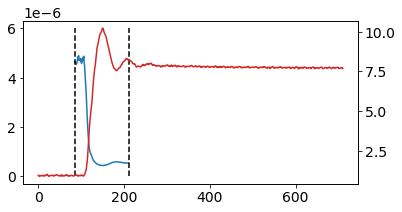

4.846809133883655e-06
0.9205722596640606
[ 84 209]
MLSi16CB7kV inital air volume = 4.846809 mL


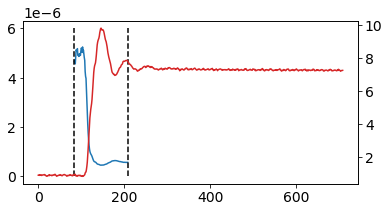

4.417419516240319e-06
0.0609438081310702
[ 91 205]
MLSi16CB7kV inital air volume = 4.417420 mL


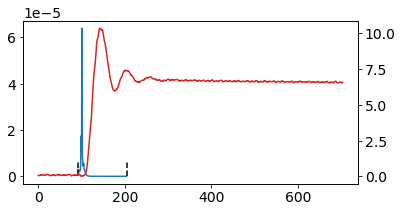

5.41908770263242e-06
1.0055728341626582
[ 67 209]
MLSi16CB7kV inital air volume = 5.419088 mL


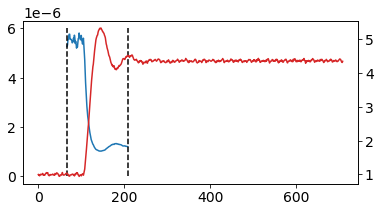

4.467361760668987e-06
0.051321101584059114
[ 89 202]
MLSi20SB7kV inital air volume = 4.467362 mL


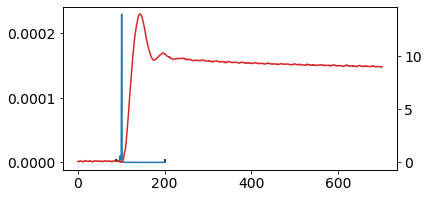

4.8784142581314405e-06
0.9430252416070863
[ 70 185]
MLSi20SB7kV inital air volume = 4.878414 mL


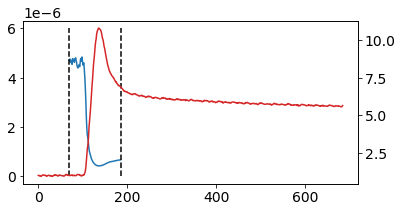

5.866002754612903e-06
2.4056766367527715
[  0 184]
MLSi20SB7kV inital air volume = 5.866003 mL


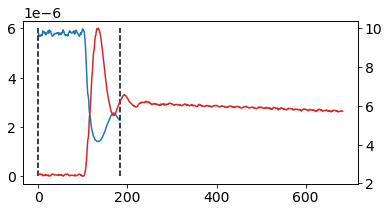

4.50333876330326e-06
0.08500057449859788
[ 81 193]
MLSi20SB7kV inital air volume = 4.503339 mL


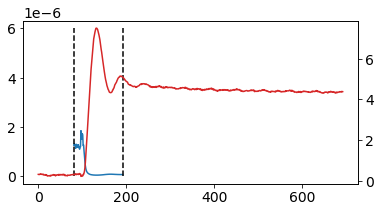

5.255464310444561e-06
1.3199145813650206
[ 42 172]
MLSi20SB7kV inital air volume = 5.255464 mL


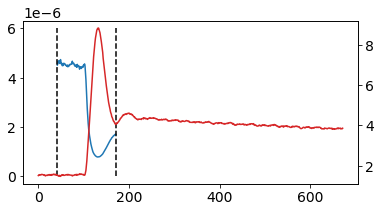

4.596582456528232e-06
0.09622706547011087
[ 79 193]
MLSi20B7kV inital air volume = 4.596582 mL


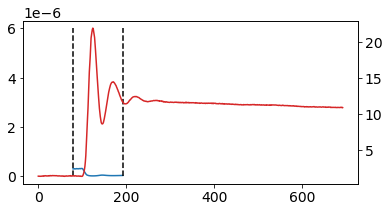

4.888855855419303e-06
1.483500592664209
[ 81 201]
MLSi20B7kV inital air volume = 4.888856 mL


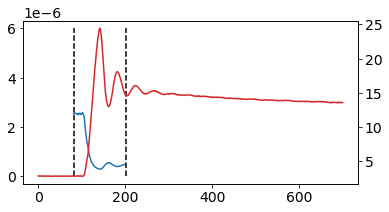

4.7647324737115075e-06
0.5741548239716614
[ 83 200]
MLSi20B7kV inital air volume = 4.764732 mL


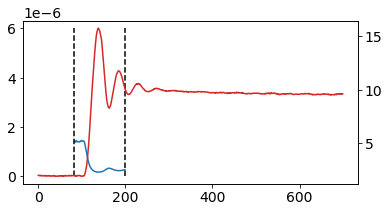

4.6016842133343075e-06
0.12990653838464983
[ 82 200]
MLSi20B7kV inital air volume = 4.601684 mL


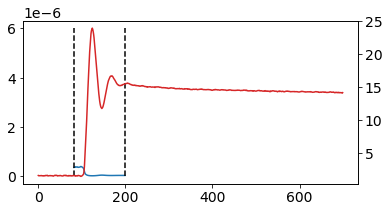

4.719388779323157e-06
0.7425521885443556
[ 76 194]
MLSi20B7kV inital air volume = 4.719389 mL


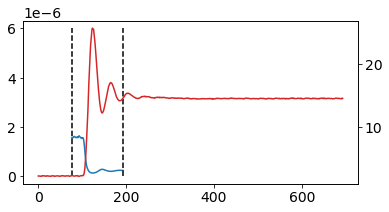

6.077560675281856e-06
3.603703601855651
[1261 2075]
FR3Tube8mm inital air volume = 6.077561 mL


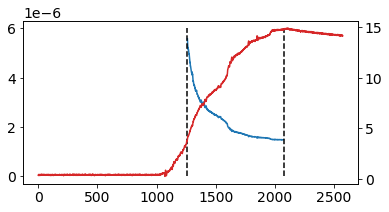

6.108756013245246e-06
3.7769123197018506
[1234 2151]
FR3Tube8mm inital air volume = 6.108756 mL


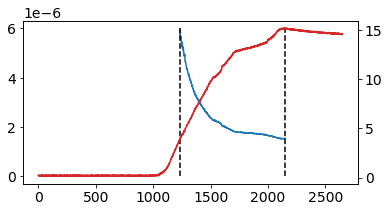

6.135371913459575e-06
3.733610140240301
[1233 2108]
FR3Tube8mm inital air volume = 6.135372 mL


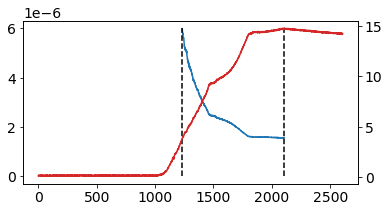

6.022160913741334e-06
3.1674742383911485
[1286 2530]
FR3Tube8mm inital air volume = 6.022161 mL


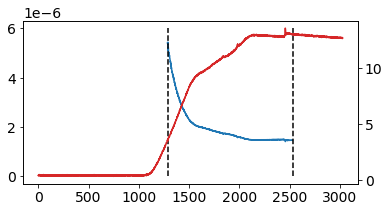

6.0618080378611695e-06
3.427287315160448
[1237 2144]
FR3Tube8mm inital air volume = 6.061808 mL


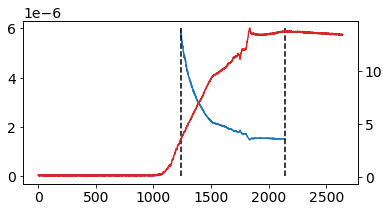

6.165252544570044e-06
2.6606783602485646
[1330 1722]
FR3MedTube inital air volume = 6.165253 mL


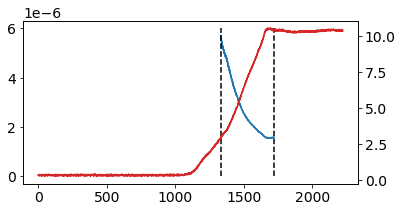

6.0769985008325305e-06
2.6446405160035464
[1330 1979]
FR3MedTube inital air volume = 6.076999 mL


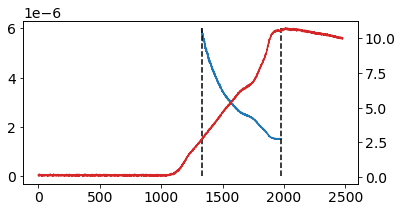

6.145043444795751e-06
2.3142609245561663
[1331 2167]
FR3MedTube inital air volume = 6.145043 mL


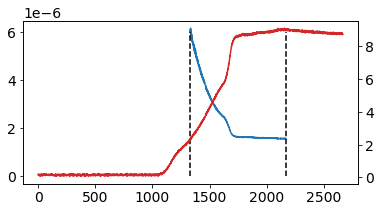

6.090988859565729e-06
3.8362523434084186
[1321 2182]
FR3MedTube inital air volume = 6.090989 mL


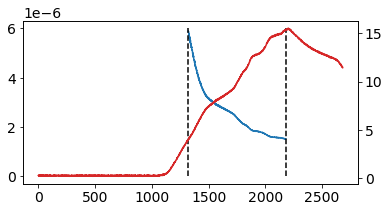

6.123166012323401e-06
2.902849808348344
[1331 2088]
FR3MedTube inital air volume = 6.123166 mL


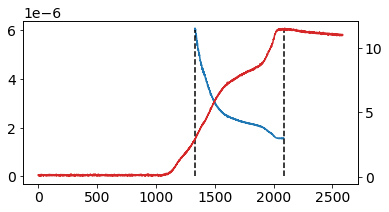

In [147]:
sigData['V0'] = 0

for i in sigData.index:
    deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

    sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa'])
    
    print(sigData.loc[i,'V0'])
    print(pressData.loc[i,'P0_kPa'])
    print(sigData.loc[i,'SegIndex'])
    
    print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
    Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3)
    
    ax,_=aPlot()
    ax.plot(np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]), Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]])
    ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
    ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
#     ax.set_ylim([0, 6e-6]);
    ax2 = ax.twinx() 
    ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
    plt.show();
